# 第６章 特徴量選択

## 初期処理

### Google Driveのマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### ライブラリのロード

In [0]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

### ファイルの読込

#### 作業用のフォルダへ移動

In [0]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


#### ファイルの読込

In [0]:
dfTips = sns.load_dataset("tips")
dfTitanic = pd.read_csv("./data/train.csv")
boston = load_boston()

dfBoston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfBoston["MEDV"] = boston.target

dfTips_back = dfTips.copy()
dfTitanic_back = dfTitanic.copy()
dfBoston_back = dfBoston.copy()

### category_encodersのインストール

In [0]:
pip install category_encoders

     |████████████████████████████████| 102kB 2.3MB/s 


In [0]:
dfTitanic = dfTitanic_back.copy()
dfTitanic = dfTitanic.dropna(how="any")
dfTitanic = dfTitanic.drop(columns=["PassengerId","Name","Ticket", "Cabin"])
dfTitanic_x = dfTitanic.drop("Survived", axis=1)
dfTitanic_y = dfTitanic["Survived"]

import category_encoders as ce

ce_oe = ce.OrdinalEncoder(cols=["Sex", "Embarked"],handle_unknown='impute')
dfTitanic_x = ce_oe.fit_transform( dfTitanic_x ).reset_index()

## 特徴量選択

### 1.a. filter method

#### SelectKBest

In [0]:
from sklearn.feature_selection import SelectKBest

In [0]:
selector = SelectKBest(k=3)
selector.fit(dfTitanic_x, dfTitanic_y)
selected_titanic = selector.transform(dfTitanic_x)
mask_titanic = selector.get_support()
print( dfTitanic_x.columns )
print( selected_titanic.shape )
print( mask_titanic )

Index(['index', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
(183, 3)
[ True False  True  True False False False False]


#### SelectPercentile

In [0]:
from sklearn.feature_selection import SelectPercentile

In [0]:
selector = SelectPercentile (percentile=25)
selector.fit(dfTitanic_x, dfTitanic_y)
selected_titanic = selector.transform(dfTitanic_x)
mask_titanic = selector.get_support()
print( dfTitanic_x.columns )
print( selected_titanic.shape )
print( mask_titanic )

Index(['index', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
(183, 2)
[False False  True  True False False False False]


#### VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold

In [0]:
selector = VarianceThreshold(threshold=2.0)
selector.fit(dfTitanic_x, dfTitanic_y)
selected_titanic = selector.transform(dfTitanic_x)
mask_titanic = selector.get_support()
print( dfTitanic_x.columns )
print( selected_titanic.shape )
print( mask_titanic )

Index(['index', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
(183, 3)
[ True False False  True False False  True False]


### 2.b. wrapper method

#### RFECV

In [0]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

In [0]:
dfTips_x = dfTips_back.drop(columns=["tip"])
dfTips_y = dfTips_back["tip"]

import category_encoders as ce
ce_oe = ce.OrdinalEncoder(cols=["sex", "smoker", "day", "time"],handle_unknown='impute')
dfTips_x = ce_oe.fit_transform( dfTips_x )

In [0]:
linearReg = LinearRegression()
rfecv = RFECV( estimator=linearReg, step=1, scoring="neg_mean_squared_error" )
rfecv.fit(dfTips_x, dfTips_y)
rfecv.transform(dfTips_x)

rf_featureImportance = pd.DataFrame(dfTips_x.columns.values, columns=["name"] )
rf_featureImportance["is_importance"] = rfecv.support_

print( rf_featureImportance )

         name  is_importance
0  total_bill           True
1         sex          False
2      smoker           True
3         day          False
4        time           True
5        size           True


#### Boruta

In [0]:
pip install Boruta

     |████████████████████████████████| 61kB 1.9MB/s 


In [0]:
from boruta import BorutaPy

In [0]:
rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
selector = BorutaPy(rfClf, n_estimators="auto",verbose=2, random_state=0)

selector.fit( dfTitanic_x.values[:,:], dfTitanic_y.ravel() )
selected_titanic = selector.transform( dfTitanic_x.values[:,:] )
mask_titanic = selector.support_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	4
Iteration: 	17 / 

In [0]:
print( dfTitanic_x.columns )
print( selected_titanic.shape )
print( mask_titanic )

Index(['index', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')
(183, 3)
[False False  True  True False False  True False]


#### Permutation Importance

###### eli5によるPermutation Importanceの実行

In [0]:
pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

dfTitanic_train_x, dfTitanic_val_x, dfTitanic_train_y, dfTitanic_val_y = train_test_split(dfTitanic_x, dfTitanic_y, test_size = 0.3, train_size = 0.7, shuffle = True, random_state =10 )

rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
rfClf.fit(dfTitanic_train_x, dfTitanic_train_y )

perm = PermutationImportance(rfClf).fit(dfTitanic_val_x, dfTitanic_val_y)
eli5.show_weights(perm)

ModuleNotFoundError: ignored

In [0]:
mask = perm.feature_importances_ > 0 
features = dfTitanic_x.columns[mask]
print( mask )
print( features )

[False False  True  True False False  True False]
Index(['Sex', 'Age', 'Fare'], dtype='object')


##### scikit-learnによるPermutation Importanceの実行

In [0]:
from sklearn.inspection import permutation_importance

In [0]:
dfTitanic_train_x, dfTitanic_val_x, dfTitanic_train_y, dfTitanic_val_y = train_test_split(dfTitanic_x, dfTitanic_y, test_size = 0.3, train_size = 0.7, shuffle = True, random_state =10 )

rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
rfClf.fit(dfTitanic_train_x, dfTitanic_train_y )

result = permutation_importance(rfClf, dfTitanic_val_x, dfTitanic_val_y, n_repeats=10, random_state=0)

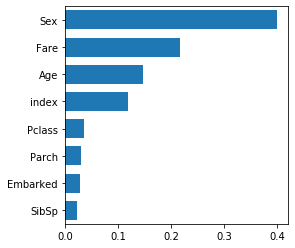

In [0]:
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rfClf.feature_importances_)
tree_indices = np.arange(0, len(rfClf.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))

ax1.barh(tree_indices, rfClf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(dfTitanic_val_x.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfClf.feature_importances_)))
plt.show()

#### 説明可能な機械学習

##### LIME

In [0]:
# limeのインストール
pip install lime

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=53cd2369f2101f906709b5c4599a5896581502598ed2b4b6e19170a2448e3d1a
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=83443090604fab27bb6ff746d89fcc92172a9f130b951f69f721a761138219b5
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
# limeのインポート
import lime
from lime.lime_tabular import LimeTabularExplainer

In [0]:
# 検証用のデータの用意
dfTitanic_x = dfTitanic_back.drop(columns=["Survived"])
dfTitanic_y = dfTitanic_back["Survived"]

# 不要な列の削除
dfTitanic_x = dfTitanic_x.drop(columns=["PassengerId","Name","Ticket","Cabin"])

# 欠損値を平均値で埋める
dfTitanic_x = dfTitanic_x.fillna( dfTitanic_x.mean() )

In [0]:
# カテゴリデータを数値に変換
import category_encoders as ce

ce_oe = ce.OrdinalEncoder(cols=["Pclass", "Sex", "SibSp", "Parch", "Embarked"],handle_unknown='impute')
dfTitanic_x = ce_oe.fit_transform( dfTitanic_x )

In [0]:
# RandomForestを用いてモデルを作成
dfTitanic_train_x, dfTitanic_val_x, dfTitanic_train_y, dfTitanic_val_y = train_test_split(dfTitanic_x, dfTitanic_y, test_size = 0.3, train_size = 0.7, shuffle = True, random_state =10 )

rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
rfClf.fit(dfTitanic_train_x, dfTitanic_train_y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
# それぞれのクラスに所属する確率を求める
y_test_pred_proba = rfClf.predict_proba(dfTitanic_val_x.values)

In [0]:
categorical_features = [0,1,6]
categorical_names = ["Pclass","Sex","Embarked"]

explainer = lime.lime_tabular.LimeTabularExplainer(
   dfTitanic_train_x.values,
   mode='classification',
   feature_names=dfTitanic_train_x.columns,
   class_names=["Not Survived", "Survived"],
   categorical_features=categorical_features, 
   categorical_names=categorical_names,
   verbose=True
   )
i = 5
exp = explainer.explain_instance(dfTitanic_val_x.values[i], rfClf.predict_proba, num_features=len(dfTitanic_val_x.columns) )
exp.show_in_notebook(show_all=False)

Intercept 0.6435159436214541
Prediction_local [0.22567688]
Right: 0.20146726934287662


In [0]:
print(y_test_pred_proba[i], exp.score, exp.intercept)

[0.79853273 0.20146727] 0.9441588167308159 {1: 0.6435159436214541}


In [0]:
exp.as_list()

[('Sex=1', -0.26599378506044347),
 ('Pclass=1', -0.0890622399019076),
 ('Fare <= 7.92', -0.05386167532537344),
 ('Embarked=1', -0.03506345100791866),
 ('SibSp <= 2.00', 0.027216592506208635),
 ('Parch <= 1.00', -0.01579674150405618),
 ('Age <= 22.00', 0.014722234990277264)]

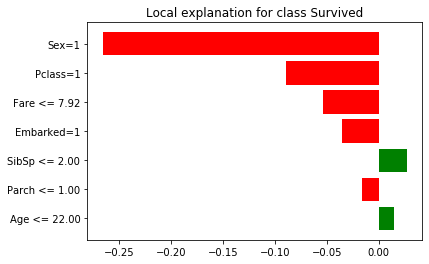

In [0]:
%matplotlib inline
fig = exp.as_pyplot_figure()

##### SHAP

In [0]:
# shapのインストール
pip install shap

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383171 sha256=b66e75c0cc9b099f54266406771ed7bd0b8edebb73ad0ba7859b84a549058552
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import shap

In [0]:
# 検証用のデータの用意
dfTitanic_x = dfTitanic_back.drop(columns=["Survived"])
dfTitanic_y = dfTitanic_back["Survived"]

# 不要な列の削除
dfTitanic_x = dfTitanic_x.drop(columns=["PassengerId","Name","Ticket","Cabin"])

# 欠損値を平均値で埋める
dfTitanic_x = dfTitanic_x.fillna( dfTitanic_x.mean() )

In [0]:
# カテゴリデータを数値に変換
import category_encoders as ce

ce_oe = ce.OrdinalEncoder(cols=["Pclass", "Sex", "SibSp", "Parch", "Embarked"],handle_unknown='impute')
dfTitanic_x = ce_oe.fit_transform( dfTitanic_x )

In [0]:
# RandomForestを用いて予測
dfTitanic_train_x, dfTitanic_val_x, dfTitanic_train_y, dfTitanic_val_y = train_test_split(dfTitanic_x, dfTitanic_y, test_size = 0.3, train_size = 0.7, shuffle = True, random_state =10 )

rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
rfClf.fit(dfTitanic_train_x, dfTitanic_train_y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
explainer = shap.KernelExplainer(rfClf.predict_proba, shap.kmeans(dfTitanic_train_x, 5))

In [0]:
n_explain = 200
shap_values = explainer.shap_values(dfTitanic_train_x[:n_explain])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [0]:
explainer.expected_value[1]

In [0]:
shap.initjs()
i = 2
shap.force_plot(base_value=explainer.expected_value[1], shap_values=shap_values[1][i],
                features=dfTitanic_train_x.loc[i,:], feature_names=dfTitanic_train_x.columns)

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1],
                dfTitanic_train_x[:n_explain], dfTitanic_train_x.columns)

In [0]:
shap.summary_plot(shap_values, dfTitanic_train_x)

In [0]:
shap.dependence_plot(
    "Sex", shap_values[1], dfTitanic_train_x[:n_explain], feature_names=dfTitanic_train_x.columns)

##### ICE

In [0]:
pip install pycebox

In [0]:
import pycebox.ice as icebox

In [0]:
# 検証用のデータの用意
dfTitanic_x = dfTitanic_back.drop(columns=["Survived"])
dfTitanic_y = dfTitanic_back["Survived"]

# 不要な列の削除
dfTitanic_x = dfTitanic_x.drop(columns=["PassengerId","Name","Ticket","Cabin"])

# 欠損値を平均値で埋める
dfTitanic_x = dfTitanic_x.fillna( dfTitanic_x.mean() )

In [0]:
# カテゴリデータを数値に変換
import category_encoders as ce

ce_oe = ce.OrdinalEncoder(cols=["Pclass", "Sex", "SibSp", "Parch", "Embarked"],handle_unknown='impute')
dfTitanic_x = ce_oe.fit_transform( dfTitanic_x )

In [0]:
# RandomForestを用いて予測
dfTitanic_train_x, dfTitanic_val_x, dfTitanic_train_y, dfTitanic_val_y = train_test_split(dfTitanic_x, dfTitanic_y, test_size = 0.3, train_size = 0.7, shuffle = True, random_state =10 )

rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
rfClf.fit(dfTitanic_train_x, dfTitanic_train_y )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
def __get_quantiles(x):
  return np.greater.outer(x, x).sum(axis=1) / x.size
icebox.__get_quantiles = __get_quantiles

In [0]:
def pred_fun(X_train):
  return rfClf.predict_proba(X_train)[:, 1]

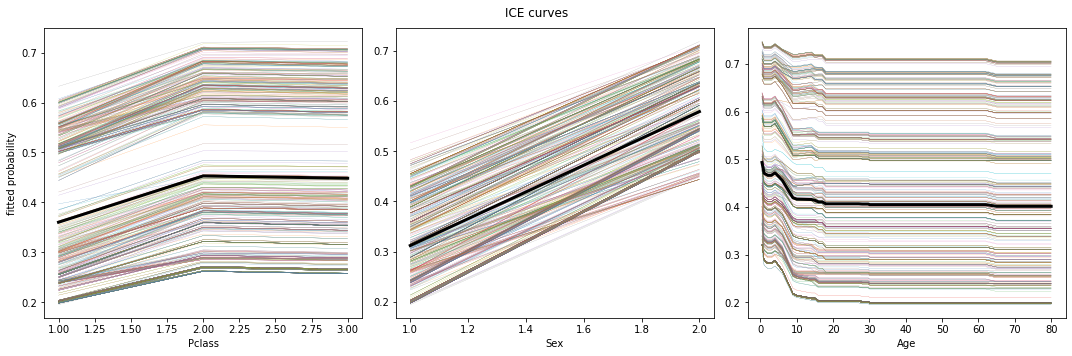

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
feature_names = ["Pclass", "Sex", "Age"]

# plot the first 3 features
for i, feature_name in enumerate(feature_names):
    # generate ICE data points
    ice_df = icebox.ice(dfTitanic_x, column=feature_name, predict=pred_fun, num_grid_points=100)

    # plot
    plt.subplot(axes[i])
    icebox.ice_plot(ice_df, linewidth=0.15, plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3}, ax=axes[i])
    axes[i].set_xlabel(feature_name)

axes[0].set_ylabel('fitted probability')
plt.suptitle('ICE curves')

##### PDP

In [0]:
from sklearn.inspection import plot_partial_dependence as pdp

/usr/local/lib/python3.6/dist-packages/sklearn/inspection/_partial_dependence.py:715: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  FutureWarning)


Text(0.5, 0.98, 'Partial Dependence Plots')

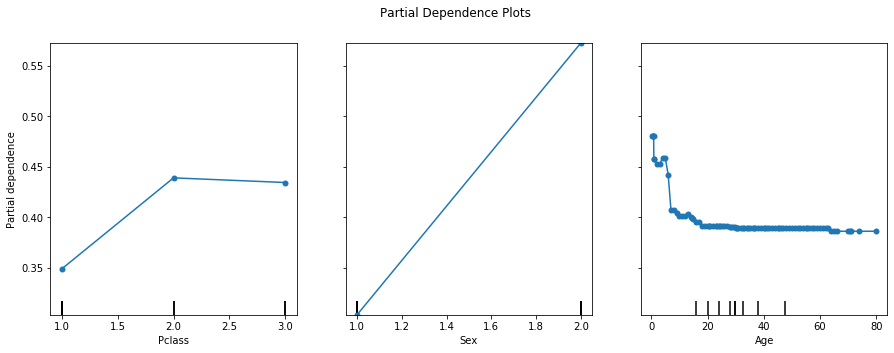

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
pdp(rfClf, dfTitanic_x, features=feature_names, feature_names=feature_names, n_cols=3, fig=fig, line_kw={'marker': 'o', 'markeredgecolor': 'None'})

plt.suptitle('Partial Dependence Plots')

### 2.c. embedded method

#### feature importance


In [0]:
rfClf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0 )
rfClf.fit(dfTitanic_x, dfTitanic_y )
rf_featureImportance = pd.DataFrame( dfTitanic_x.columns.values, columns=["name"] )
rf_featureImportance["importance"] = rfClf.feature_importances_

print( rf_featureImportance )

#### Lasso

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfBoston)
dfBoston = pd.DataFrame(scaler.transform(dfBoston), columns=dfBoston.columns)

In [0]:
boston_x = dfBoston.drop(columns = ["MEDV"], axis = 1 )
boston_y = dfBoston.MEDV
boston_train_x, boston_test_x, boston_train_y, boston_test_y = train_test_split(boston_x, boston_y, test_size = 0.3, train_size = 0.7, shuffle = True, random_state =10 )

In [0]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(boston_train_x, boston_train_y)

print("決定係数：テスト用>>", lr.score(boston_test_x, boston_test_y))

In [0]:
from sklearn import linear_model
lsr = linear_model.Lasso( alpha=0.1 )

lsr.fit(boston_train_x, boston_train_y)

print("決定係数：テスト用>>", lsr.score(boston_test_x, boston_test_y))
print( boston_train_x.columns[ lsr.coef_ != 0 ] ) 
print( len( boston_train_x.columns ) )